In [60]:
from functools import partial
from numbers import Real
from matplotlib import pyplot
from pandas import Series
from sklearn.pipeline import make_pipeline
from tpot import TPOTClassifier

from hcve_lib.analysis import missing_values
from hcve_lib.functional import pipe, star_args

from deps.data import load_data
from deps.data import load_metadata
from hcve_lib.data import get_survival_y, binarize_survival, format_value, find_item, format_features
from hcve_lib.data import get_X
from hcve_lib.data import remove_nan_target
from hcve_lib.visualisation import h3, b, display_number

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
pyplot.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
metadata = load_metadata()

data = load_data()

data.drop(['DBIRTH', 'DVISIT'], axis=1, inplace=True)


In [118]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

2021-10-03 16:50:08,796 - ERROR    - Internal Python error in the inspect module.
Below is the traceback from this internal error.

2021-10-03 16:50:08,815 - INFO     - 
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_385259/3228173245.py", line 4, in <module>
    profile
  File "/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/IPython/core/displayhook.py", line 262, in __call__
    format_dict, md_dict = self.compute_format_data(result)
  File "/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/IPython/core/displayhook.py", line 151, in compute_format_data
    return self.shell.display_formatter.format(result)
  File "/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/

TypeError: object of type 'NoneType' has no len()

Exception in thread Thread-177:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 558, in run
    self.terminate_broken(bpe)
  File "/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 736, in terminate_broken
    self.kill_workers()
  File "/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 766, in kill_workers
    recursive_terminate(p)
  File "/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N

Error in callback <function flush_figures at 0x7f7ffb58eaf0> (for post_execute):


KeyboardInterrupt: 

In [65]:

b('Input rows')
display_number(len(data))

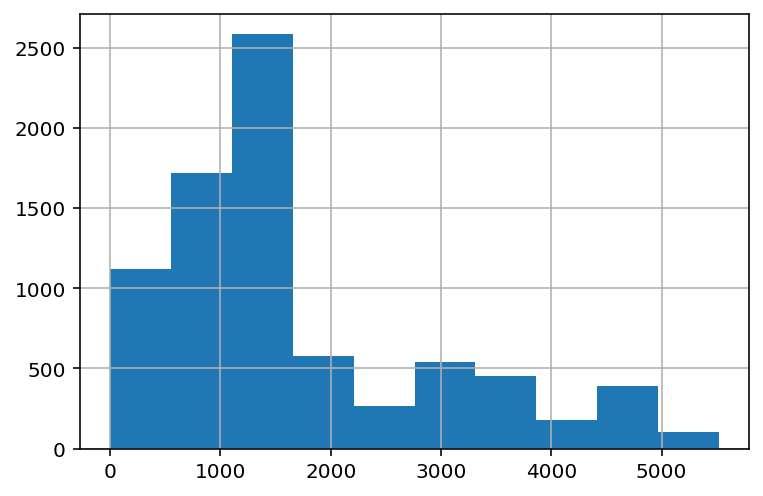

In [55]:
b('Cardiovascular death histogram')

data['FUFCV'].hist();


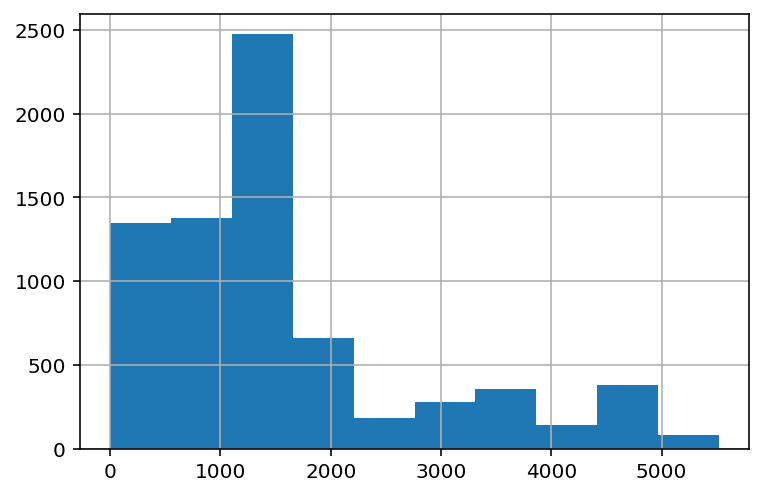

In [57]:
b('Non-fatal heart failure histogram')
data['FUNFHF'].hist();

In [114]:
data['FUFNFHF'].describe()

count     160.000000
mean      739.843750
std       527.707103
min         1.000000
25%       256.000000
50%       691.000000
75%      1177.000000
max      1998.000000
Name: FUFNFHF, dtype: float64

<AxesSubplot:title={'center':'Fatal or non-fatal heart failure'}>

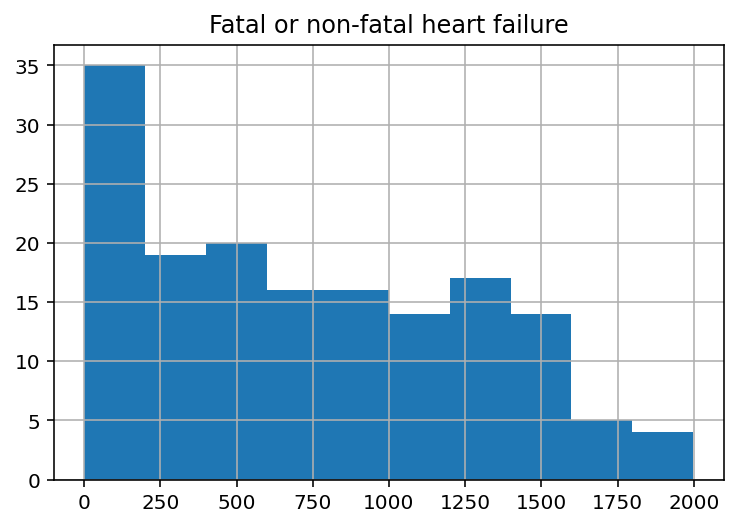

In [111]:
pyplot.title('Fatal or non-fatal heart failure')
data['FUFNFHF'].hist()

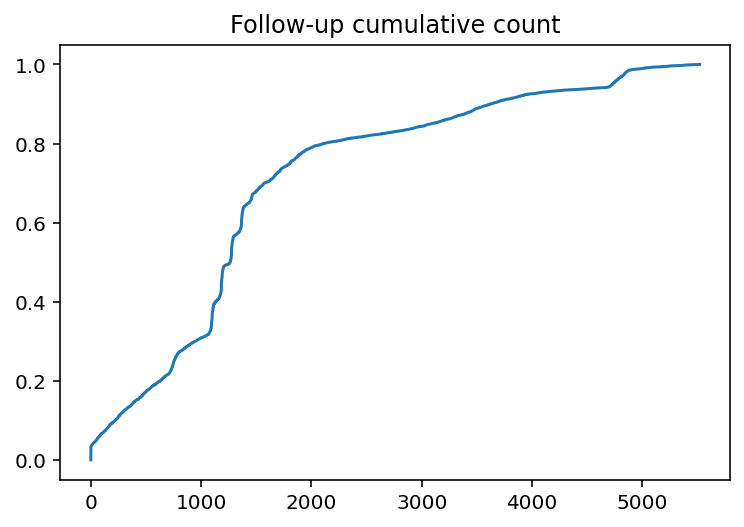

In [106]:

from hcve_lib.functional import unzip
from hcve_lib.utils import cumulative_count

pyplot.title('Follow-up cumulative count')
pyplot.plot(*unzip(cumulative_count(data['FUNFHF'].dropna())));


In [116]:

from hcve_lib.data import format_dataframe
import dtale


d = pipe(
    data,
    partial(format_dataframe, metadata=metadata),
    dtale.show
)
d.notebook()


In [16]:
# import pandas_profiling
#
# pandas_profiling.ProfileReport(data)


In [ ]:

# for study_num, cohort in data.groupby('STUDY_NUM'):
#     h3(format_value(study_num, find_item('STUDY_NUM', metadata)))
#     missing_values(cohort, metadata)
#     pyplot.show()
# # savefig(f'{OUTPUT_PATH}/missing_features.png')


In [77]:
from sklearn.model_selection import train_test_split

X, y = pipe(
    (
        get_X(data, metadata),
        binarize_survival(5*365, get_survival_y(data, 'NFHF', metadata)),
    ),
    star_args(remove_nan_target)
)


b('Input rows after binarization')
display_number(len(X))

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
)

X_train = X_train.dropna(thresh=0.7, axis=1)

b('Input rows after removing missing columns')
display_number(len(X))
y_train = y_train.loc[X_train.index]

<AxesSubplot:>

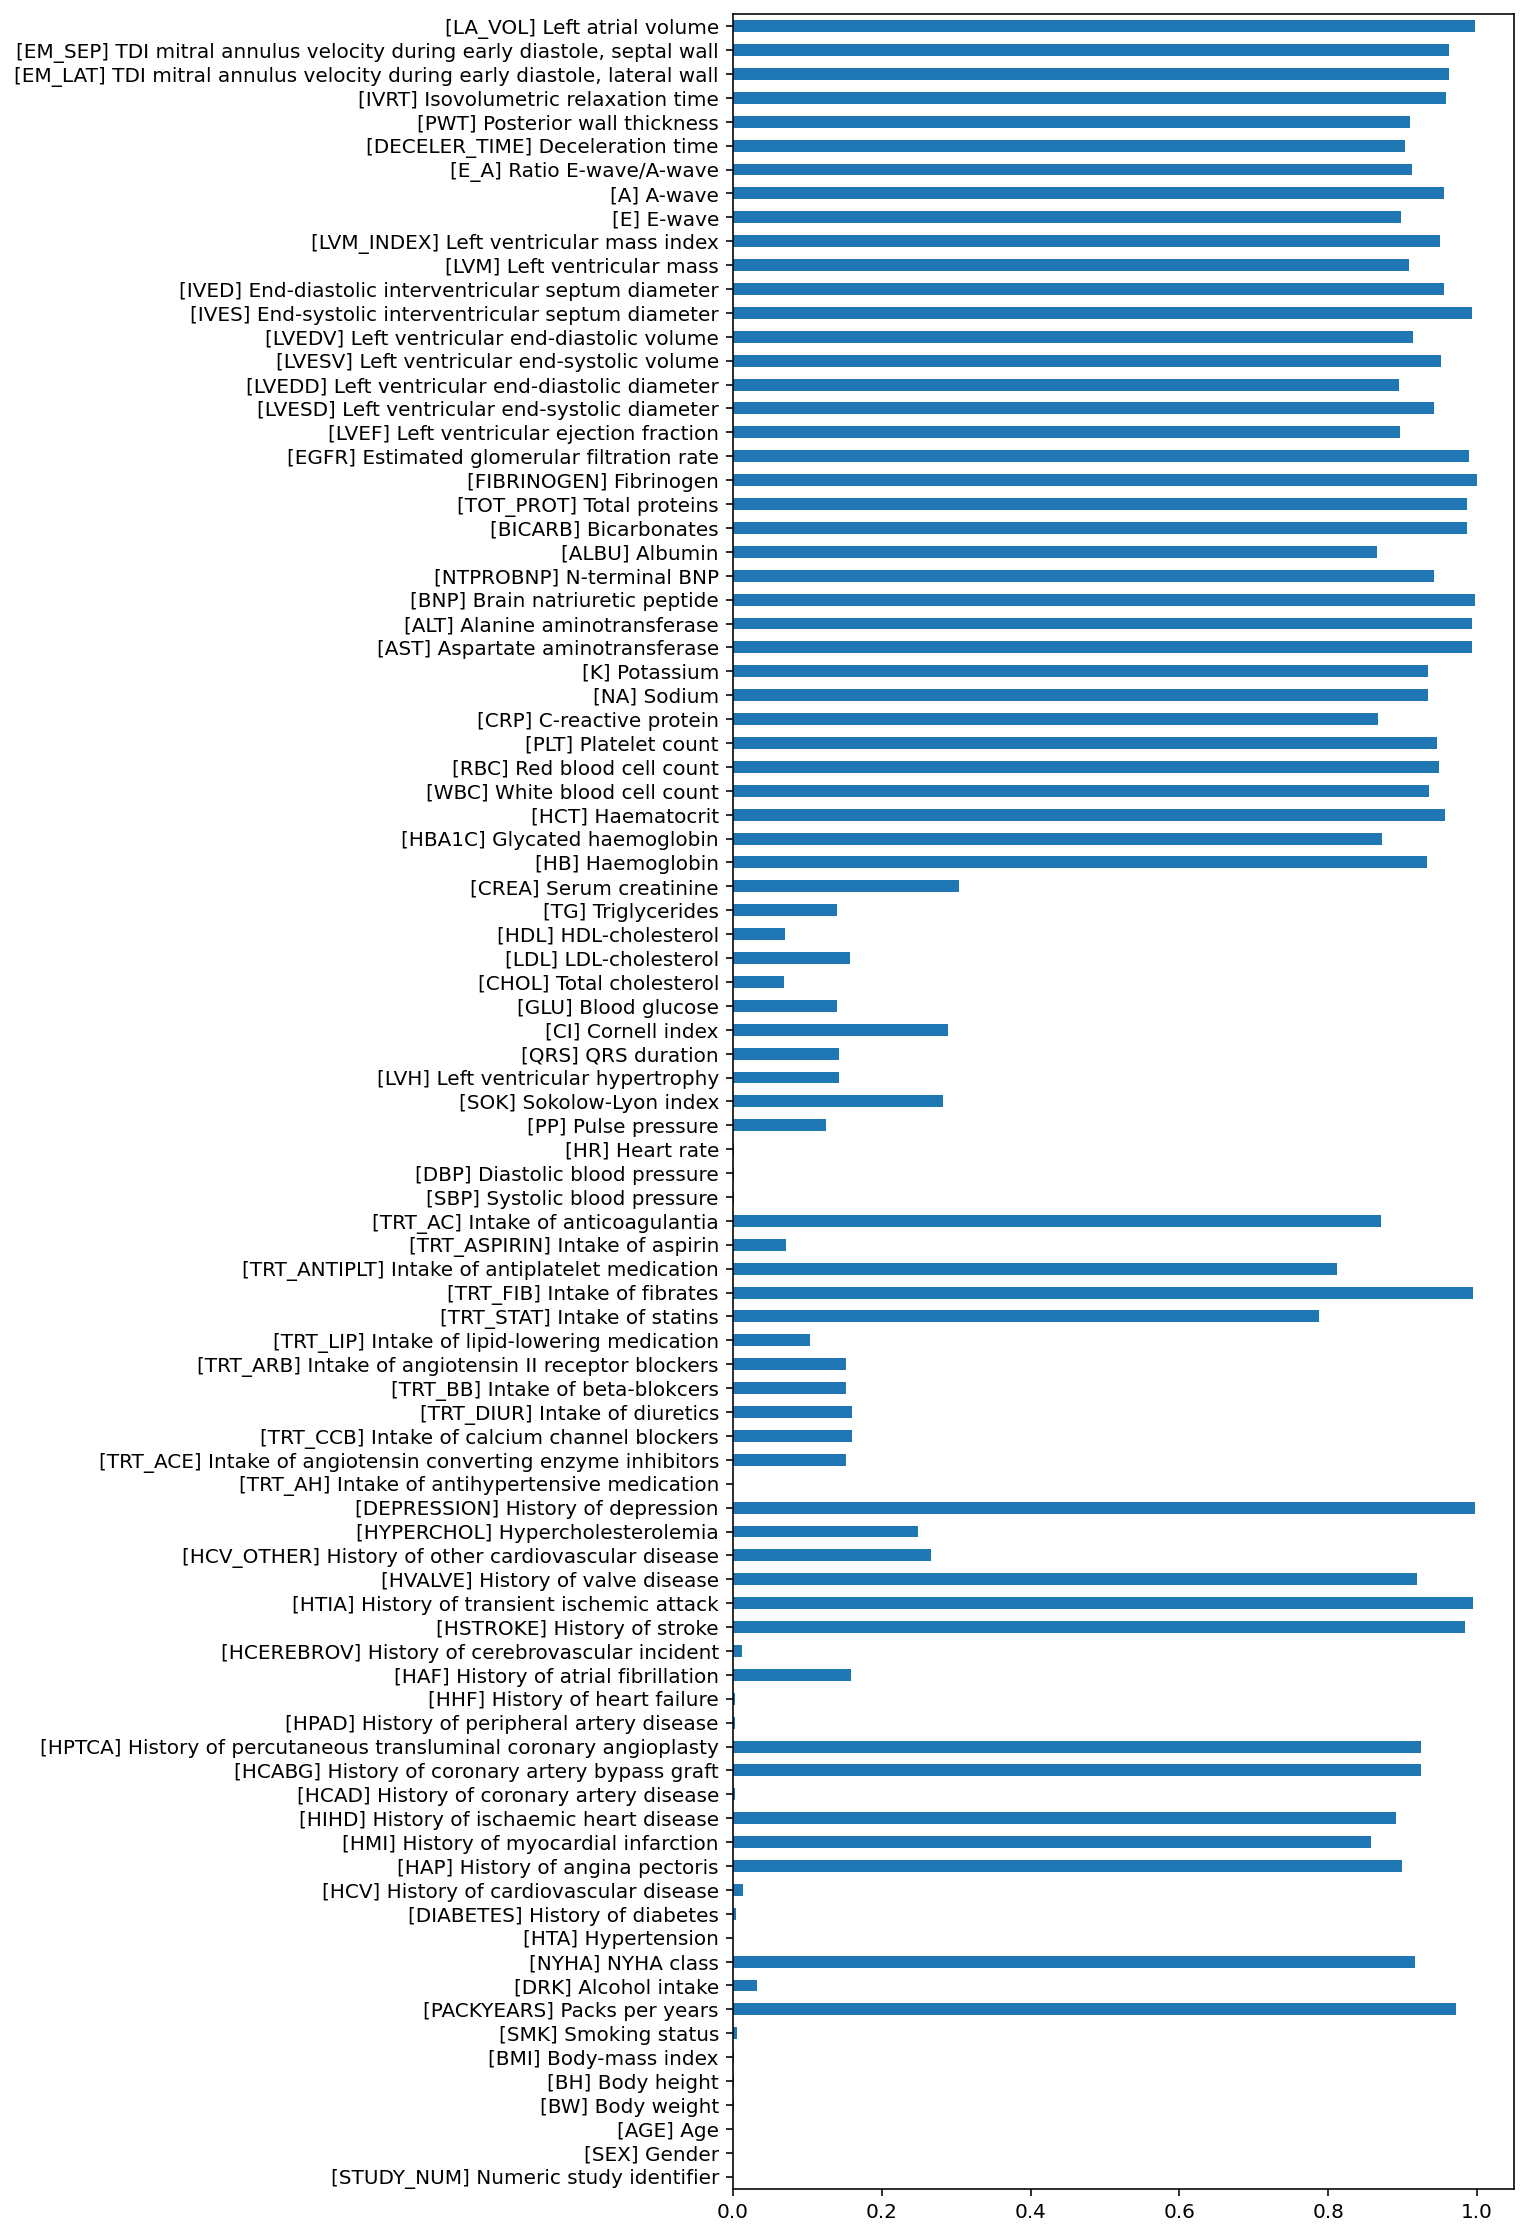

In [43]:
pyplot.figure(figsize=(7,20))
missing = (X_train.isna().sum() / len(X_train))
format_features(missing, metadata=metadata, axis=0).plot(kind='barh')



In [45]:
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure(1, figsize=(4, 3))
pyplot.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

pyplot.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

# for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
#     ax.text3D(X[y == label, 0].mean(),
#               X[y == label, 1].mean() + 1.5,
#               X[y == label, 2].mean(), name,
#               horizontalalignment='center',
#               bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# # Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=pyplot.cm.nipy_spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

pyplot.show()

0

In [12]:

import pandas

pandas.set_option('display.max_rows', 500)

data.dtypes

,STUDY_NUM,SEX,AGE,BW,BH,BMI,SMK,PACKYEARS,DRK,NYHA,...,LVM_INDEX,E,A,E_A,DECELER_TIME,PWT,IVRT,EM_LAT,EM_SEP,LA_VOL
20141,3,1.0,82.000000,68.0,170.00,23.529412,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10422,2,1.0,49.462012,78.0,172.00,26.365603,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25698,8,1.0,74.000000,66.0,167.25,23.594549,2.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2220,2,1.0,62.527036,63.0,170.00,21.799308,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8045,2,2.0,76.465435,41.0,150.00,18.222222,1.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19412,2,1.0,70.576318,77.0,175.00,25.142857,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18863,2,1.0,57.316906,100.0,173.00,33.412409,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3594,2,1.0,47.917864,85.0,182.00,25.661152,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22106,6,1.0,51.526352,88.0,179.00,27.464811,2.0,NaN,1.0,NaN,...,NaN,85.2523,NaN,1.511243,165.650607,0.879711,NaN,18.053324,13.50981,NaN


In [70]:
X_train

,STUDY_NUM,SEX,AGE,BW,BH,BMI,SMK,PACKYEARS,DRK,NYHA,...,LVM_INDEX,E,A,E_A,DECELER_TIME,PWT,IVRT,EM_LAT,EM_SEP,LA_VOL
4603,2,1.0,78.302533,67.500000,174.000000,22.294887,1.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13571,2,1.0,52.966461,112.500000,178.000000,35.506880,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29497,10,1.0,86.099998,79.300003,166.999996,28.400000,2.0,NaN,0.0,3.0,...,116.300003,170.000005,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN
28005,10,2.0,39.400002,119.300003,159.000003,47.200001,1.0,NaN,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4054,2,1.0,59.915127,96.000000,181.000000,29.303135,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8387,2,1.0,47.501711,64.000000,172.000000,21.633315,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11789,2,1.0,63.184120,85.800000,169.000000,30.040965,2.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14984,2,1.0,62.850103,77.800000,168.000000,27.565193,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25317,8,2.0,72.000000,70.799988,157.500000,28.541189,2.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
from hcve_lib.custom_types import FoldPrediction
from hcve_lib.evaluation_functions import compute_classification_metrics_from_result
from autoimpute.imputations import MiceImputer

pipeline_optimizer = make_pipeline(
    MiceImputer(),
    TPOTClassifier(),
)
pipeline_optimizer.fit(X_train, y_train)

y_score = pipeline_optimizer.predict_proba(X_test)

metrics = compute_classification_metrics_from_result([FoldPrediction(y_true=y_test, y_score=y_score)])

print(metrics)

/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass fit_intercept=True, normalize=False, copy_X=True, n_jobs=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


ValueError: Found array with 0 sample(s) (shape=(0, 90)) while a minimum of 1 is required.

In [66]:
from sklearn.preprocessing import OrdinalEncoder
from visions import Ordinal
from hcve_lib.custom_types import FoldPrediction
from hcve_lib.evaluation_functions import compute_classification_metrics_from_result

pipeline_optimizer = make_pipeline(
    OrdinalEncoder(),
    TPOTClassifier(),
)
pipeline_optimizer.fit(X_train, y_train)

y_score = pipeline_optimizer.predict_proba(X_test)

metrics = compute_classification_metrics_from_result([FoldPrediction(y_true=y_test, y_score=y_score)])

print(metrics)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: '11Apr2002'

378      0.0
379      0.0
380      0.0
381      0.0
382      0.0
        ... 
52626    0.0
52627    0.0
52628    0.0
52629    0.0
52630    0.0
Length: 37904, dtype: float64